Данные успешно загружены
Размер данных: (8057, 19)

Первые 5 строк данных:
          cve_id                                       project  \
0  CVE-2016-6307            https://github.com/openssl/openssl   
1            NaN  https://github.com/AFNetworking/AFNetworking   
2  CVE-2017-6797          https://github.com/mantisbt/mantisbt   
3            NaN          https://github.com/joomla/joomla-cms   
4            NaN                  https://github.com/curl/curl   

                                        sha   dataset   cwe_id  \
0  c1ef7c971d0bbf117c3c80f65b5875e2e7b024b1  SECBENCH  CWE-400   
1  c23c37ab4ab9b2401e824df717538e37bc5c85a4  SECBENCH  CWE-401   
2  c272c3f65da9677e505ff692b1f1e476b3afa56e  SECBENCH   CWE-79   
3  c277c23c617d5a9eddd2a45b7a438460d5fc6f15  SECBENCH   CWE-89   
4  c2a809cd265c37e7bbef55e64d70114d2f0d7189  SECBENCH  CWE-401   

           vuln_type  score  \
0  Denial Of Service    4.3   
1                NaN    NaN   
2                NaN    4.3   
3      

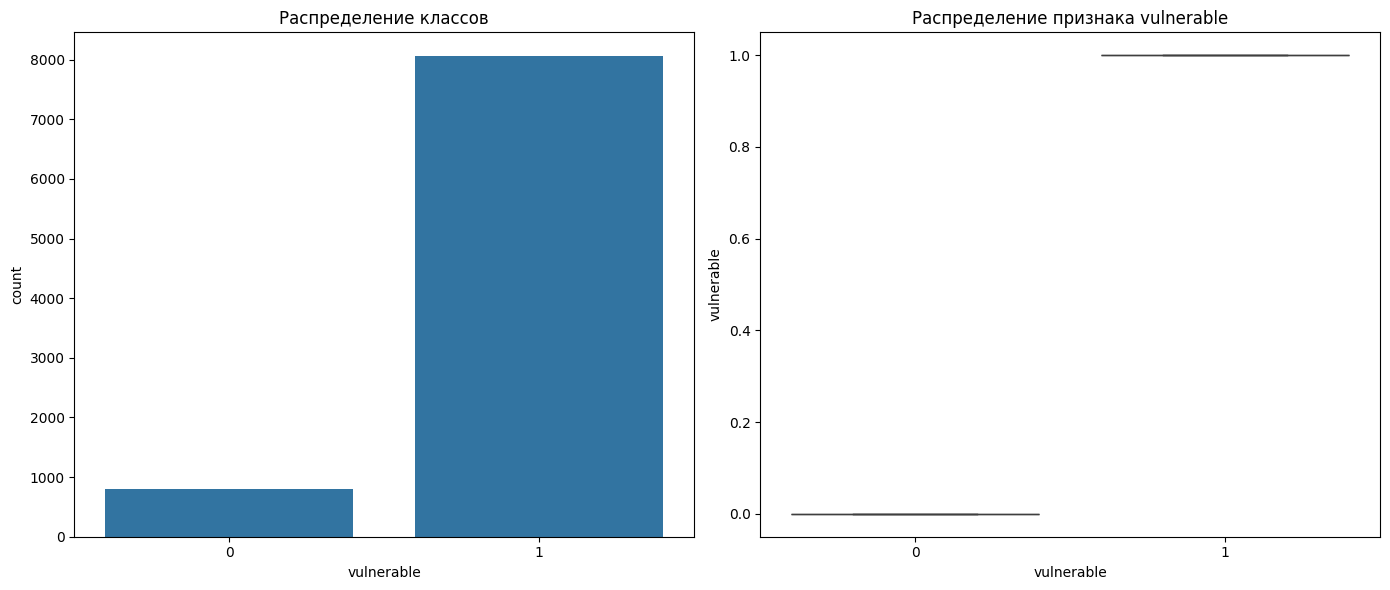


Применяем SMOTE для балансировки классов...

Результаты кросс-валидации (F1-score):
Логистическая регрессия: 0.40 [Время: 3.5 сек]
Случайный лес: 0.86 [Время: 53.3 сек]
SVM: 0.41 [Время: 1413.3 сек]

Обучение лучшей модели (Случайный лес)...

Отчет классификации:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2418
           1       0.90      0.94      0.92      2417

    accuracy                           0.91      4835
   macro avg       0.92      0.91      0.91      4835
weighted avg       0.92      0.91      0.91      4835



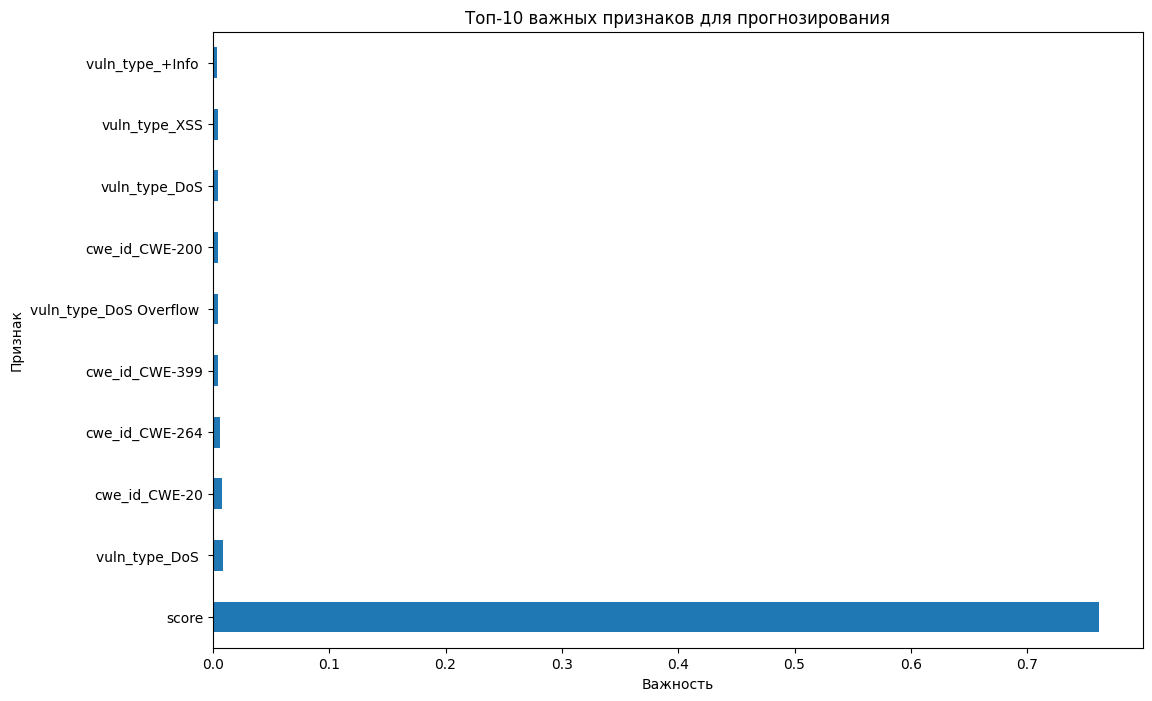

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Загрузка и проверка данных
try:
    df = pd.read_csv('security_patches.csv')
    print("Данные успешно загружены")
    print(f"Размер данных: {df.shape}")
    print("\nПервые 5 строк данных:")
    print(df.head())
except Exception as e:
    print(f"Ошибка загрузки: {e}")
    exit()

# Функция предобработки данных
def preprocess_data(raw_df):
    # Удаление нерелевантных столбцов
    cols_to_drop = [
        'cve_id', 'sha', 'github', 'summary',
        'message', 'author', 'parents',
        'ext_files', 'files', 'lang',
        'comments', 'dataset', 'date', 'project'
    ]
    df_clean = raw_df.drop(columns=cols_to_drop, errors='ignore')

    # Преобразование целевой переменной
    df_clean['vulnerable'] = df_clean['vulnerable'].map({'yes': 1, 'no': 0}).fillna(0)

    # Добавление синтетических примеров (если все уязвимы)
    if df_clean['vulnerable'].sum() == len(df_clean):
        print("\nОбнаружены только уязвимые примеры. Генерация синтетических данных...")
        n_samples = max(1, len(df_clean) // 10)
        synthetic_data = df_clean.sample(n_samples, random_state=42).copy()
        synthetic_data['vulnerable'] = 0

        # Добавление шума в числовые признаки
        numeric_cols = synthetic_data.select_dtypes(include=np.number).columns.drop('vulnerable')
        for col in numeric_cols:
            synthetic_data[col] *= np.random.uniform(0.8, 1.2, size=len(synthetic_data))

        df_clean = pd.concat([df_clean, synthetic_data], ignore_index=True)

    # Кодирование категориальных переменных
    categorical_cols = ['cwe_id', 'language', 'vuln_type']
    df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

    # Обработка пропусков
    numeric_cols = df_clean.select_dtypes(include=np.number).columns
    df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

    return df_clean

# Обработка данных
processed_df = preprocess_data(df)
print("\nПризнаковое пространство после обработки:")
print(f"Кол-во признаков: {len(processed_df.columns)}")
print("Список признаков:", list(processed_df.columns))

# Визуализация данных
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='vulnerable', data=processed_df)
plt.title('Распределение классов')

plt.subplot(1, 2, 2)
sample_feature = processed_df.select_dtypes(include=np.number).columns[1]
sns.boxplot(x='vulnerable', y=sample_feature, data=processed_df)
plt.title(f'Распределение признака {sample_feature}')
plt.tight_layout()
plt.show()

# Подготовка данных для моделирования
X = processed_df.drop('vulnerable', axis=1)
y = processed_df['vulnerable']

# Балансировка классов
if y.mean() > 0.7:
    print("\nПрименяем SMOTE для балансировки классов...")
    X, y = SMOTE(random_state=42).fit_resample(X, y)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Инициализация и оценка моделей
models = {
    'Логистическая регрессия': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    'Случайный лес': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=150,
        random_state=42
    ),
    'SVM': SVC(
        class_weight='balanced',
        probability=True,
        kernel='rbf',
        random_state=42
    )
}

print("\nРезультаты кросс-валидации (F1-score):")
for name, model in models.items():
    start_time = time.time()
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1', n_jobs=-1)
    print(f"{name}: {np.mean(scores):.2f} [Время: {time.time()-start_time:.1f} сек]")

# Обучение лучшей модели
print("\nОбучение лучшей модели (Случайный лес)...")
best_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
best_model.fit(X_train, y_train)

# Оценка на тестовых данных
y_pred = best_model.predict(X_test)
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred))

# Визуализация важности признаков
feature_importance = pd.Series(
    best_model.feature_importances_,
    index=processed_df.drop('vulnerable', axis=1).columns
)
plt.figure(figsize=(12, 8))
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Топ-10 важных признаков для прогнозирования')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()